<a href="https://colab.research.google.com/github/yiyixuxu/polyloss-pytorch/blob/master/tutorial_testing_polyloss_with_fastai_and_W%26B.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PolyLoss


__Polyloss__ was introduced by [this fantastic paper](https://paperswithcode.com/paper/polyloss-a-polynomial-expansion-perspective-1) that came out a week ago. It is a general framework that can naturally subsume cross-entropy loss,  focal loss, and other losses. It outperforms the cross-entropy loss and focal loss on 2D image classification, instance segmentation, object detection, and 3D object detection tasks. and most amazingly, it only introduce one hyperparameter and require minimum change of code

In this tutorial, we will see see an example of how to use PolyLoss in fast.ai and how to search its hyperparameter with Weights & Biases

## install libraries

we are going to use [PyTorch Image Models](https://github.com/rwightman/pytorch-image-models) (timm) imodels from fastai - install both `fasti` and `timm`

In [1]:
%%capture
! pip install timm
! [ -e /content ] && pip install -Uqq fastai  # upgrade fastai on colab

In [2]:
import fastai
print(fastai.__version__)

2.6.3


In [3]:
import timm 

In [4]:
from fastai.vision.all import *

## download the dataset

In [5]:
URLs.IMAGENETTE

'https://s3.amazonaws.com/fast-ai-imageclas/imagenette2.tgz'

In [6]:
path = untar_data(URLs.IMAGENETTE)

In [7]:
os.listdir(path)

['train', 'val', 'noisy_imagenette.csv']

## Create DataLoaders

In [8]:
dls = ImageDataLoaders.from_folder(path, valid='val', item_tfms=Resize(256))

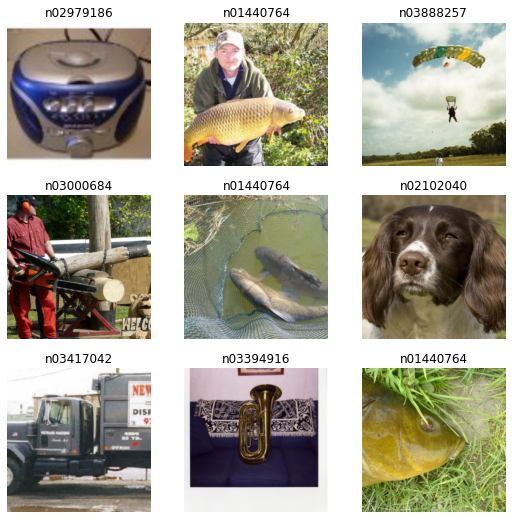

In [9]:
dls.show_batch()

## define PolyLoss in fast.ai (`PolyLossFlat`)

In [13]:
! git clone https://github.com/yiyixuxu/polyloss-pytorch.git

Cloning into 'polyloss-pytorch'...
remote: Enumerating objects: 24, done.
remote: Counting objects: 100% (24/24), done.
remote: Compressing objects: 100% (20/20), done.
remote: Total 24 (delta 5), reused 11 (delta 2), pack-reused 0
Unpacking objects: 100% (24/24), done.


In [14]:
%cd polyloss-pytorch

/content/polyloss-pytorch


In [15]:
from PolyLoss import to_one_hot, PolyLoss

In [16]:
class PolyLossFlat(BaseLoss):
    "Same as `PolyLoss`, but flattens input and target."
    y_int = True
    @use_kwargs_dict(softmax=True, ce_weight=None, reduction='mean',epsilon=1.)
    def __init__(self, **kwargs): super().__init__(PolyLoss, **kwargs)
    def decodes(self, x):   
      return x.squeeze(1).argmax(dim=1)
    def activation(self, x): return F.softmax(x, dim=1)

## train the model

Choose a `timm` model 

* `timm.list_models()` allows you to search for models using Wildcard
* if you want to know more about how to choose a model, please read this wonderful notebook from Jeremy Howard
https://www.kaggle.com/code/jhoward/which-image-models-are-best/
* in this example I choose `resnet18` for simplicity

In [ ]:
timm.list_models('*resnet*')

In [18]:
MODEL_NAME = 'resnet18'

create a minimum `fast.ai` learner with `resnet18` and `PolyLossFlat` as `loss_func` , and train!

* note that when `epsilon=0` (i.e. $\epsilon_1$ in the math below), `PolyLoss` is same as `CrossEntropyLoss` 


<center><img src="https://latex.codecogs.com/svg.image?L_\text{poly-1}&space;=-\log(P_t)&space;&plus;&space;\epsilon_1&space;\cdot&space;(1-P_t) "></center>


In [22]:
learn = vision_learner(dls, MODEL_NAME, pretrained=False, loss_func= PolyLossFlat(epsilon=0),metrics=accuracy)
learn.fit_one_cycle(5)

epoch,train_loss,valid_loss,accuracy,time
0,2.424128,2.443478,0.320764,00:35
1,1.810721,2.037225,0.374268,00:35
2,1.340856,2.082083,0.444586,00:34
3,1.068324,0.962744,0.689682,00:34
4,0.950666,0.833280,0.738599,00:34


look at some results

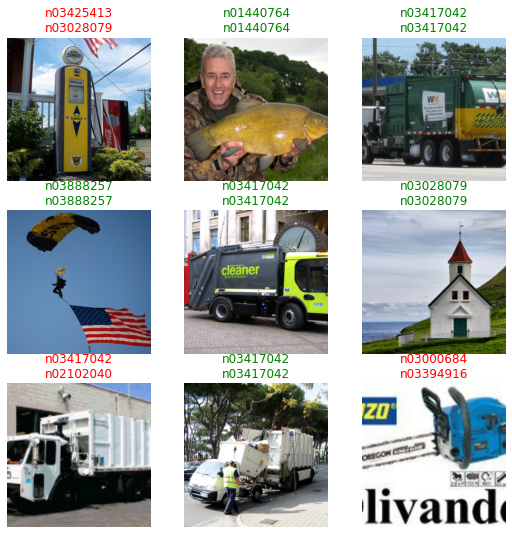

In [21]:
learn.show_results()

where the model made the worse predictions

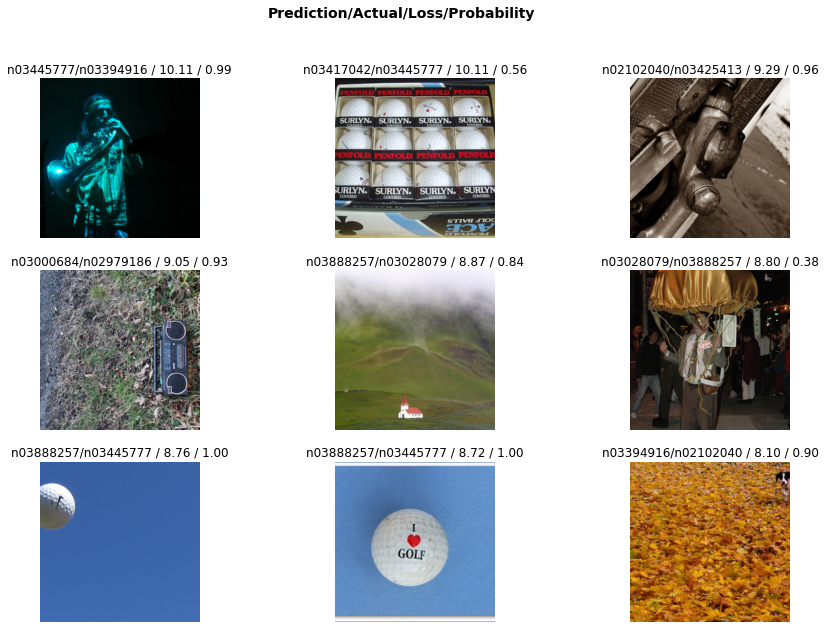

In [23]:
interp = Interpretation.from_learner(learn)
interp.plot_top_losses(9, figsize=(15,10))

# Hyperparameter tunning with Weights & Biases 

as mentioned in the [PolyLoss paper](https://arxiv.org/abs/2204.12511?context=cs), in order to achieve best result with PolyLoss, the value of `eplison` needs to be adjusted for different task and data. In this notebook, we are going to use Weights & Biases to do a quick hyperparameter search for `eplison`

For our purpose, and to keep this tutorial simple, I will only do a simple grid search. You can definately launch a hyperparameter sweep with different combination of hyperparameters. This tool can handle massive scale. To learn more, see [this tutorial about Hyperparameter sweep in Weights & biases](https://colab.research.google.com/github/wandb/examples/blob/master/colabs/pytorch/Organizing_Hyperparameter_Sweeps_in_PyTorch_with_W%26B.ipynb)

Weights & Biases is integrated with fast.ai so it is very easy to use 

### setup

If you don't have an account yet, sign up [Weights & Biases account here](https://wandb.ai/signup)


In [18]:
%%capture
!pip install wandb --upgrade
import wandb
from fastai.callback.wandb import *

In [ ]:
wandb.login()

define a `PROJECT_NAME`

In [20]:
PROJECT_NAME = 'poly1_coef_sweep'

## define the sweep

In [27]:
sweep_config = {
    'method': 'grid'
    }
metric = {
    'name': 'accuracy',
    'goal': 'maximize'   
    }

sweep_config['metric'] = metric
parameters_dict = {
    'poly1_eps': {
        'values': [-1.,0.,1.,2.,3.,4.,5.,6.,7.]
        },
    }
sweep_config['parameters'] = parameters_dict

In [22]:
import pprint

pprint.pprint(sweep_config)

{'method': 'grid',
 'metric': {'goal': 'maximize', 'name': 'accuracy'},
 'parameters': {'poly1_eps': {'values': [-1.0,
                                         0.0,
                                         1.0,
                                         2.0,
                                         3.0,
                                         4.0,
                                         5.0,
                                         6.0,
                                         7.0]}}}


## define Trainning process

* note that this `polysweep_train` function will be called by `wandb.agent`, so the wandb run's  `config` will be set by Sweep Controller based on the sweep you defined in the last step
* in our example, we only search 1 hyperparameter, i.e. the `epsilon` argument for `PolyLossFlat`, we create a `PolyLossFlat` object with `PolyLossFlat(epsilon=config.poly1_eps)`
* add `WandbCallback()` to `learner` will automatically log your losses and metric continuously for all training phases


In [31]:
def polysweep_train(config=None):
  with wandb.init(project=PROJECT_NAME, group='polyloss',config=config) as run:
    config = wandb.config
    learn = vision_learner(dls, MODEL_NAME, pretrained=False, loss_func= PolyLossFlat(epsilon=config.poly1_eps),metrics=accuracy,cbs=WandbCallback())
    learn.fit_one_cycle(5)

## sweep!

In [32]:
sweep_id = wandb.sweep(sweep_config, project=PROJECT_NAME)

Create sweep with ID: hgv8auz8
Sweep URL: https://wandb.ai/yiyixu/poly1_coef_sweep/sweeps/hgv8auz8


In [33]:
wandb.agent(sweep_id, polysweep_train, count=5)

wandb: Agent Starting Run: zfjp1uor with config:
wandb: 	poly1_eps: -1
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


WandbCallback requires use of "SaveModelCallback" to log best model


epoch,train_loss,valid_loss,accuracy,time
0,1.706207,1.705568,0.271847,00:36
1,1.192643,0.812276,0.518981,00:36
2,0.875854,0.884534,0.499873,00:36
3,0.695066,0.549686,0.669554,00:36
4,0.599061,0.487700,0.703949,00:37


torch.Size([36, 10])
torch.Size([36, 10])
torch.Size([36, 10])
torch.Size([36, 10])
torch.Size([36, 10])


accuracy,▁▅▅▇█
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
eps_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
eps_1,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
lr_0,▁▂▂▃▄▅▆▇▇██████▇▇▇▇▇▆▆▆▅▅▄▄▄▃▃▃▂▂▂▂▁▁▁▁▁
lr_1,▁▂▂▃▄▅▆▇▇██████▇▇▇▇▇▆▆▆▅▅▄▄▄▃▃▃▂▂▂▂▁▁▁▁▁
mom_0,██▇▇▅▄▃▂▂▁▁▁▁▁▁▂▂▂▂▂▃▃▃▄▄▅▅▅▆▆▆▇▇▇▇█████
mom_1,██▇▇▅▄▃▂▂▁▁▁▁▁▁▂▂▂▂▂▃▃▃▄▄▅▅▅▆▆▆▇▇▇▇█████
raw_loss,█▆▆▅▄▄▄▅▄▄▅▄▃▃▄▃▃▃▃▂▃▂▂▂▂▂▂▂▂▂▂▁▁▂▂▁▁▁▂▁
sqr_mom_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
sqr_mom_1,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁


wandb: Agent Starting Run: nohntkxj with config:
wandb: 	poly1_eps: 0
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


WandbCallback requires use of "SaveModelCallback" to log best model


epoch,train_loss,valid_loss,accuracy,time
0,2.409107,2.997595,0.246369,00:35
1,1.829568,1.721760,0.432611,00:36
2,1.358709,1.191044,0.613503,00:36
3,1.089980,0.999567,0.676943,00:36
4,0.931088,0.828487,0.736815,00:36


torch.Size([36, 10])
torch.Size([36, 10])
torch.Size([36, 10])
torch.Size([36, 10])
torch.Size([36, 10])


accuracy,▁▄▆▇█
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
eps_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
eps_1,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
lr_0,▁▂▂▃▄▅▆▇▇██████▇▇▇▇▇▆▆▆▅▅▄▄▄▃▃▃▂▂▂▂▁▁▁▁▁
lr_1,▁▂▂▃▄▅▆▇▇██████▇▇▇▇▇▆▆▆▅▅▄▄▄▃▃▃▂▂▂▂▁▁▁▁▁
mom_0,██▇▇▅▄▃▂▂▁▁▁▁▁▁▂▂▂▂▂▃▃▃▄▄▅▅▅▆▆▆▇▇▇▇█████
mom_1,██▇▇▅▄▃▂▂▁▁▁▁▁▁▂▂▂▂▂▃▃▃▄▄▅▅▅▆▆▆▇▇▇▇█████
raw_loss,███▅▆▄▄▅▅▄▄▄▄▅▄▃▃▃▃▃▂▃▃▃▂▂▂▃▁▁▃▃▂▂▁▁▂▂▁▁
sqr_mom_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
sqr_mom_1,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁


wandb: Agent Starting Run: u18sir7i with config:
wandb: 	poly1_eps: 1
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


WandbCallback requires use of "SaveModelCallback" to log best model


epoch,train_loss,valid_loss,accuracy,time
0,3.051798,3.141063,0.338344,00:36
1,2.489613,2.099486,0.515414,00:36
2,1.873155,1.754405,0.609427,00:36
3,1.496927,1.353966,0.699108,00:36
4,1.292710,1.175623,0.738344,00:36


torch.Size([36, 10])
torch.Size([36, 10])
torch.Size([36, 10])
torch.Size([36, 10])
torch.Size([36, 10])


accuracy,▁▄▆▇█
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
eps_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
eps_1,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
lr_0,▁▂▂▃▄▅▆▇▇██████▇▇▇▇▇▆▆▆▅▅▄▄▄▃▃▃▂▂▂▂▁▁▁▁▁
lr_1,▁▂▂▃▄▅▆▇▇██████▇▇▇▇▇▆▆▆▅▅▄▄▄▃▃▃▂▂▂▂▁▁▁▁▁
mom_0,██▇▇▅▄▃▂▂▁▁▁▁▁▁▂▂▂▂▂▃▃▃▄▄▅▅▅▆▆▆▇▇▇▇█████
mom_1,██▇▇▅▄▃▂▂▁▁▁▁▁▁▂▂▂▂▂▃▃▃▄▄▅▅▅▆▆▆▇▇▇▇█████
raw_loss,██▇▇▅▇▆▅▅▆▄▅▄▄▃▄▄▄▃▃▂▃▃▃▃▃▂▂▂▂▁▃▁▂▁▂▂▂▃▂
sqr_mom_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
sqr_mom_1,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁


wandb: Agent Starting Run: w1gs0zbd with config:
wandb: 	poly1_eps: 2
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


WandbCallback requires use of "SaveModelCallback" to log best model


epoch,train_loss,valid_loss,accuracy,time
0,3.857526,4.196339,0.297834,00:36
1,2.955993,3.532091,0.413503,00:36
2,2.290961,3.497360,0.455796,00:36
3,1.823083,1.703177,0.703694,00:36
4,1.575943,1.484669,0.741911,00:36


torch.Size([36, 10])
torch.Size([36, 10])
torch.Size([36, 10])
torch.Size([36, 10])
torch.Size([36, 10])


accuracy,▁▃▃▇█
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
eps_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
eps_1,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
lr_0,▁▂▂▃▄▅▆▇▇██████▇▇▇▇▇▆▆▆▅▅▄▄▄▃▃▃▂▂▂▂▁▁▁▁▁
lr_1,▁▂▂▃▄▅▆▇▇██████▇▇▇▇▇▆▆▆▅▅▄▄▄▃▃▃▂▂▂▂▁▁▁▁▁
mom_0,██▇▇▅▄▃▂▂▁▁▁▁▁▁▂▂▂▂▂▃▃▃▄▄▅▅▅▆▆▆▇▇▇▇█████
mom_1,██▇▇▅▄▃▂▂▁▁▁▁▁▁▂▂▂▂▂▃▃▃▄▄▅▅▅▆▆▆▇▇▇▇█████
raw_loss,█▇▆▅▅▅▅▃▆▅▄▄▄▄▃▅▃▂▄▂▃▂▂▃▃▂▂▂▂▁▂▂▁▂▂▁▁▂▂▂
sqr_mom_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
sqr_mom_1,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: hsu3plug with config:
wandb: 	poly1_eps: 3
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


WandbCallback requires use of "SaveModelCallback" to log best model


epoch,train_loss,valid_loss,accuracy,time
0,4.520653,4.493808,0.345732,00:36
1,3.554694,4.876462,0.398981,00:36
2,2.740656,2.314033,0.668790,00:36
3,2.213240,2.089455,0.697325,00:36
4,1.913042,1.784501,0.745223,00:36


torch.Size([36, 10])
torch.Size([36, 10])
torch.Size([36, 10])
torch.Size([36, 10])
torch.Size([36, 10])


accuracy,▁▂▇▇█
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
eps_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
eps_1,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
lr_0,▁▂▂▃▄▅▆▇▇██████▇▇▇▇▇▆▆▆▅▅▄▄▄▃▃▃▂▂▂▂▁▁▁▁▁
lr_1,▁▂▂▃▄▅▆▇▇██████▇▇▇▇▇▆▆▆▅▅▄▄▄▃▃▃▂▂▂▂▁▁▁▁▁
mom_0,██▇▇▅▄▃▂▂▁▁▁▁▁▁▂▂▂▂▂▃▃▃▄▄▅▅▅▆▆▆▇▇▇▇█████
mom_1,██▇▇▅▄▃▂▂▁▁▁▁▁▁▂▂▂▂▂▃▃▃▄▄▅▅▅▆▆▆▇▇▇▇█████
raw_loss,███▇▆▇▇▆▆▅▅▅▅▄▄▄▄▃▃▃▄▄▃▄▃▃▂▂▂▂▃▃▂▂▃▁▂▂▂▂
sqr_mom_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
sqr_mom_1,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁


## sweep results
 

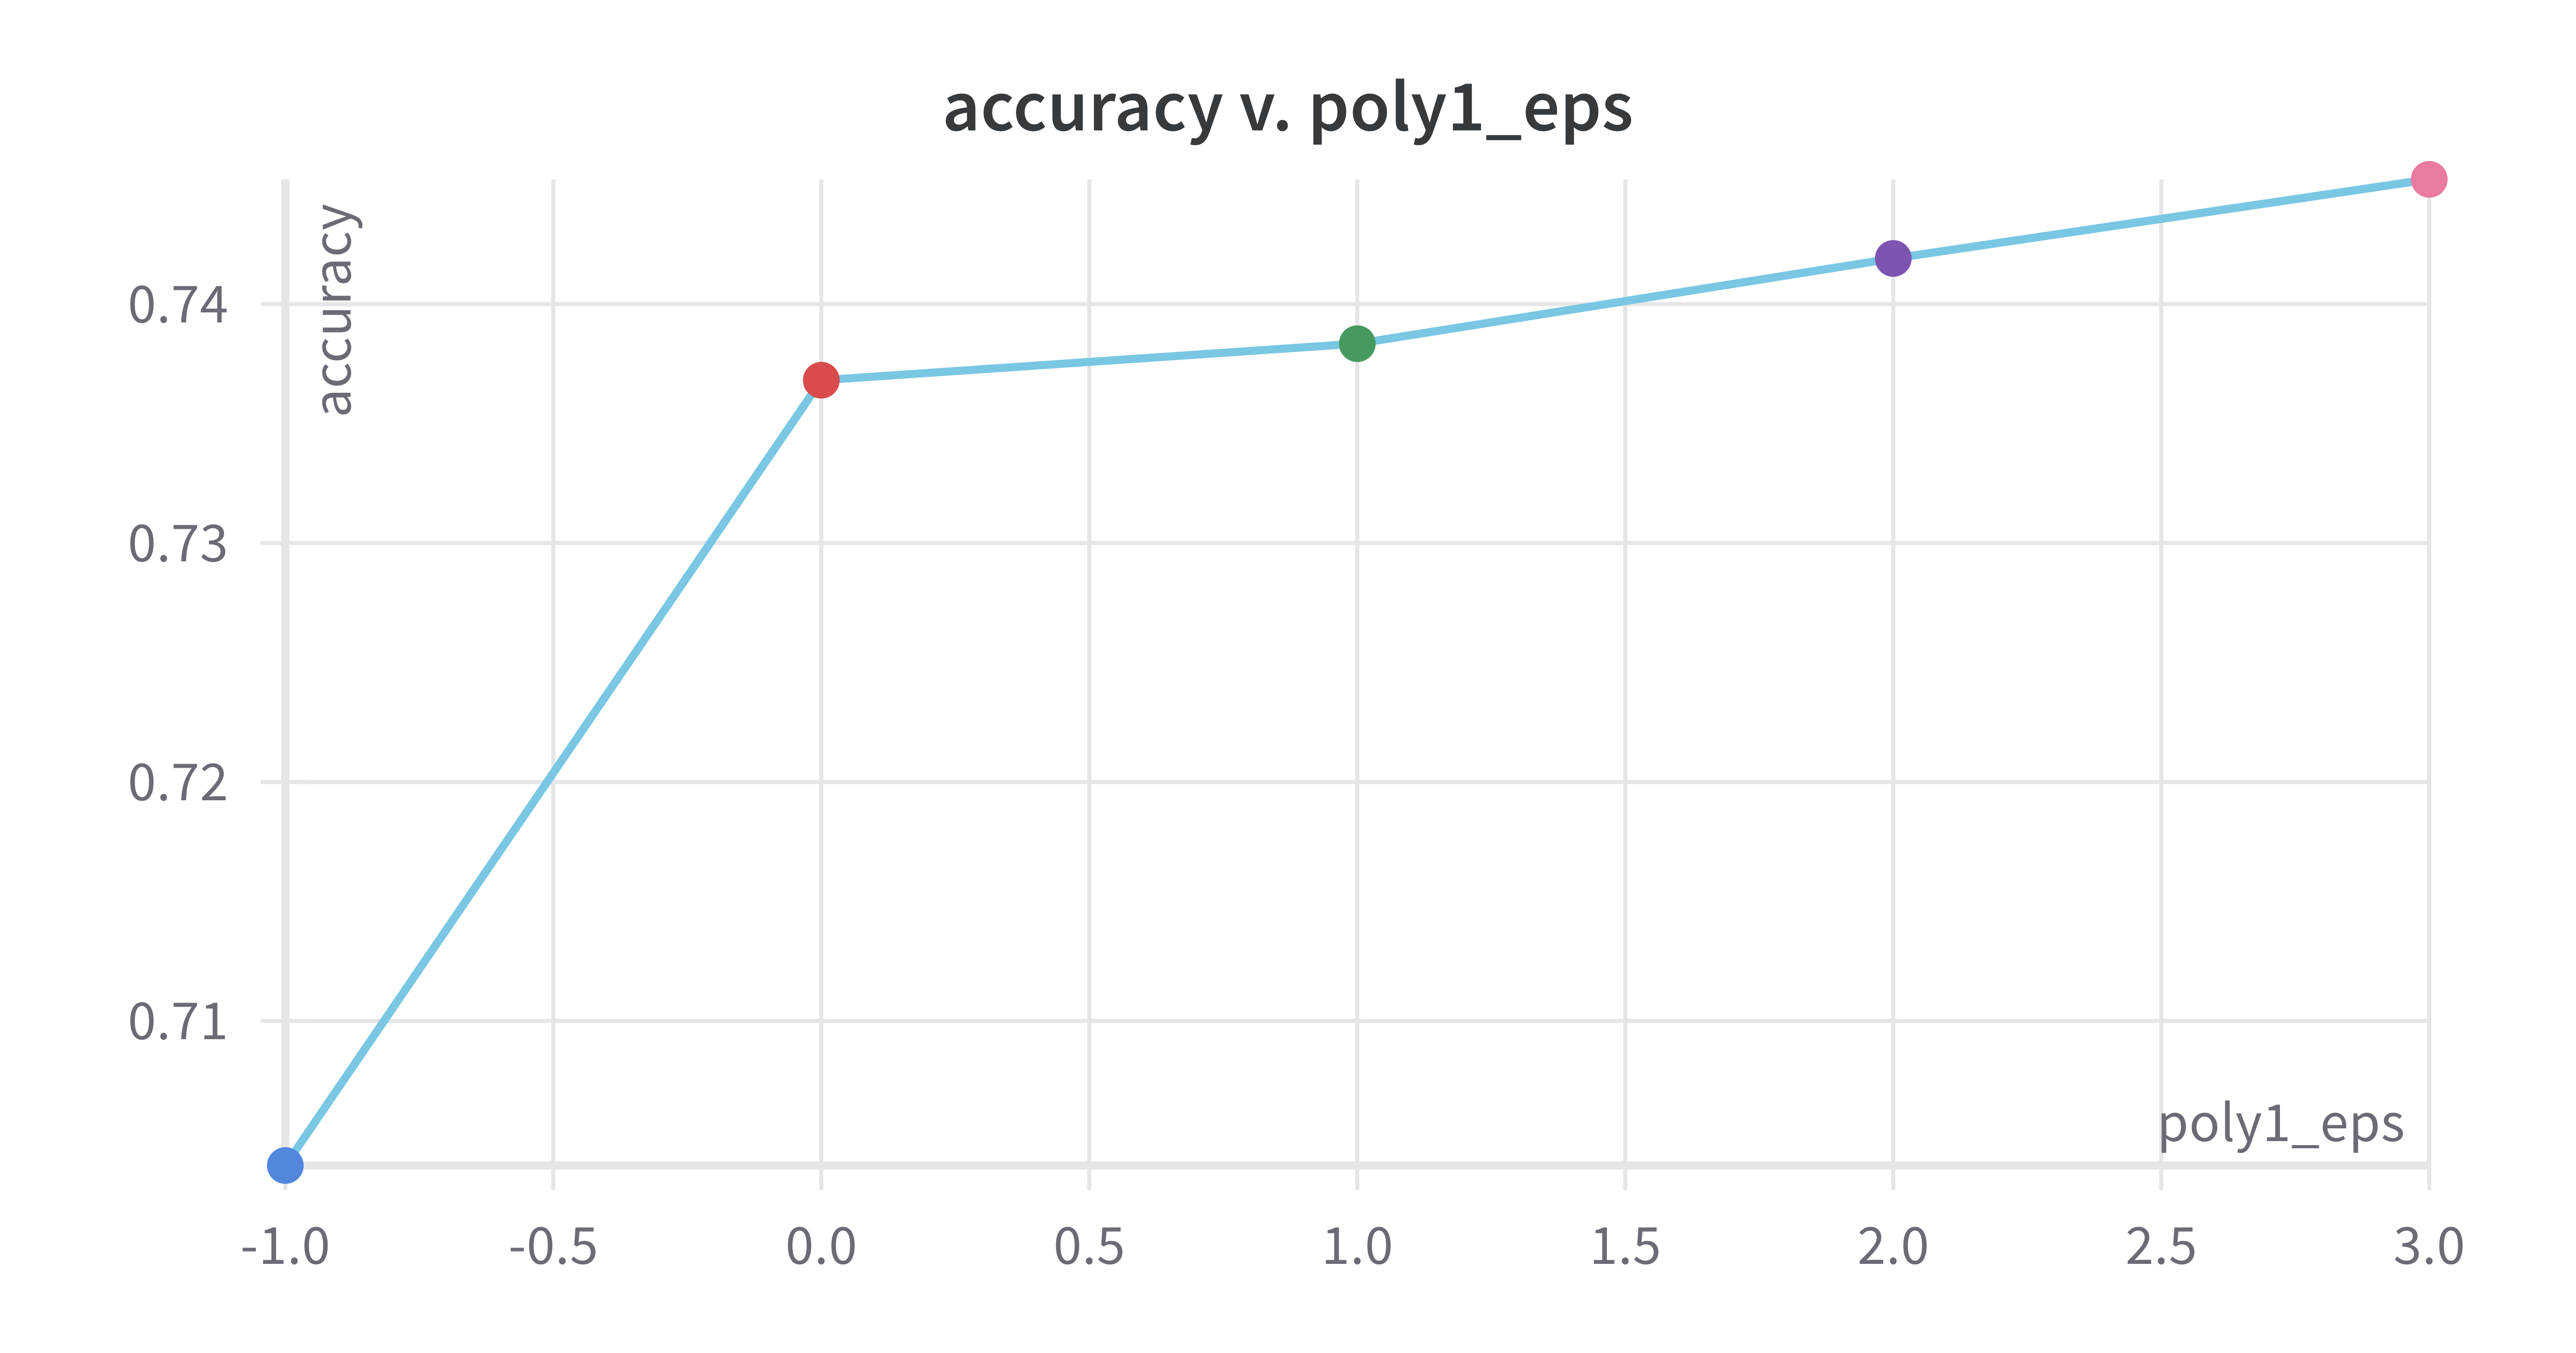